<a href="https://colab.research.google.com/github/anjitha30/British-Airways-Customer-Feedback-Analysis/blob/main/British_Airways_Customer_Feedback_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

### Install required libraries

In [1]:
#pip install requests beautifulsoup4 pandas nltk textblob wordcloud matplotlib scikit-learn

### Scrape the Data

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [3]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())

    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


### Clean and Prepare the Data

In [4]:
df = pd.DataFrame()
df["reviews"] = reviews
df

,reviews
0,"✅ Trip Verified | Terrible overall, medium ser..."
1,✅ Trip Verified | London Heathrow to Male In...
2,Not Verified | Very good flight following an ...
3,Not Verified | An hour's delay due to late ar...
4,✅ Trip Verified | I booked through BA becaus...
...,...
995,✅ Trip Verified | I purchased a ticket for Du...
996,✅ Trip Verified | London to Shanghai. The Con...
997,Not Verified | I have often flown British Air...
998,Not Verified | Good morning. I would like to ...


In [5]:
import os

# Create the 'data' directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# Now you can save the DataFrame to the CSV file
df.to_csv("data/BA_reviews.csv")

Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

In [6]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [7]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to clean text
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])  # Remove stopwords and lemmatize
    return text

# Apply cleaning to the 'Review' column
df['Cleaned_Review'] = df['reviews'].apply(clean_text)

### Sentiment Analysis:

In [8]:
from textblob import TextBlob

# Perform sentiment analysis
df['Sentiment'] = df['Cleaned_Review'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['Sentiment_Label'] = df['Sentiment'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')

# Display sentiment distribution
print(df['Sentiment_Label'].value_counts())

Sentiment_Label
positive    620
negative    363
neutral      17
Name: count, dtype: int64


#### Sentiment Distribution:
A pie chart or bar chart showing the proportion of positive, negative, and neutral reviews.

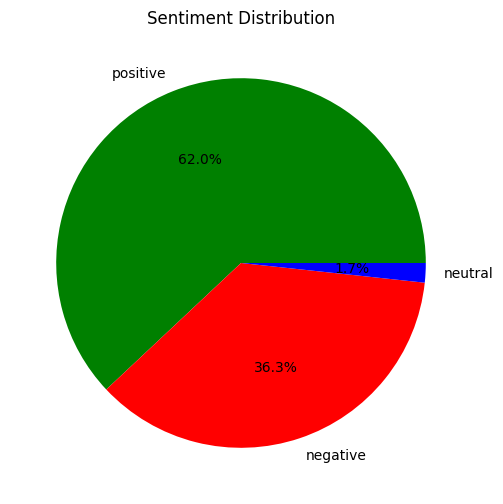

In [9]:
import matplotlib.pyplot as plt

# Sentiment counts
sentiment_counts = df['Sentiment_Label'].value_counts()

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['green', 'red', 'blue'])
plt.title('Sentiment Distribution')
plt.show()

<ipython-input-10-42c9028aafdb>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment_Label', data=df, palette=['green', 'red', 'blue'])


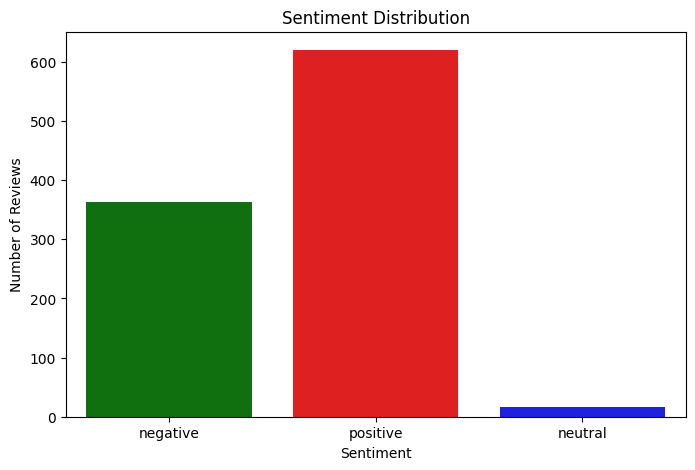

In [10]:
import seaborn as sns

# Plot sentiment distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Sentiment_Label', data=df, palette=['green', 'red', 'blue'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

### Topic Modeling:
Topic modeling using Latent Dirichlet Allocation (LDA) to identify common topics in the reviews

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vectorize the text data
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df['Cleaned_Review'])

# Perform LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Number of top words per topic
no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

Topic 0:
flight ba airline trip airway british service day seat hour
Topic 1:
flight ba hour trip service time staff customer british bag
Topic 2:
seat flight crew good ba food trip cabin class service
Topic 3:
flight service staff seat ba food trip london airline hour
Topic 4:
ba business plane trip flight late hour london class minute


Bar Chart for Top Topics

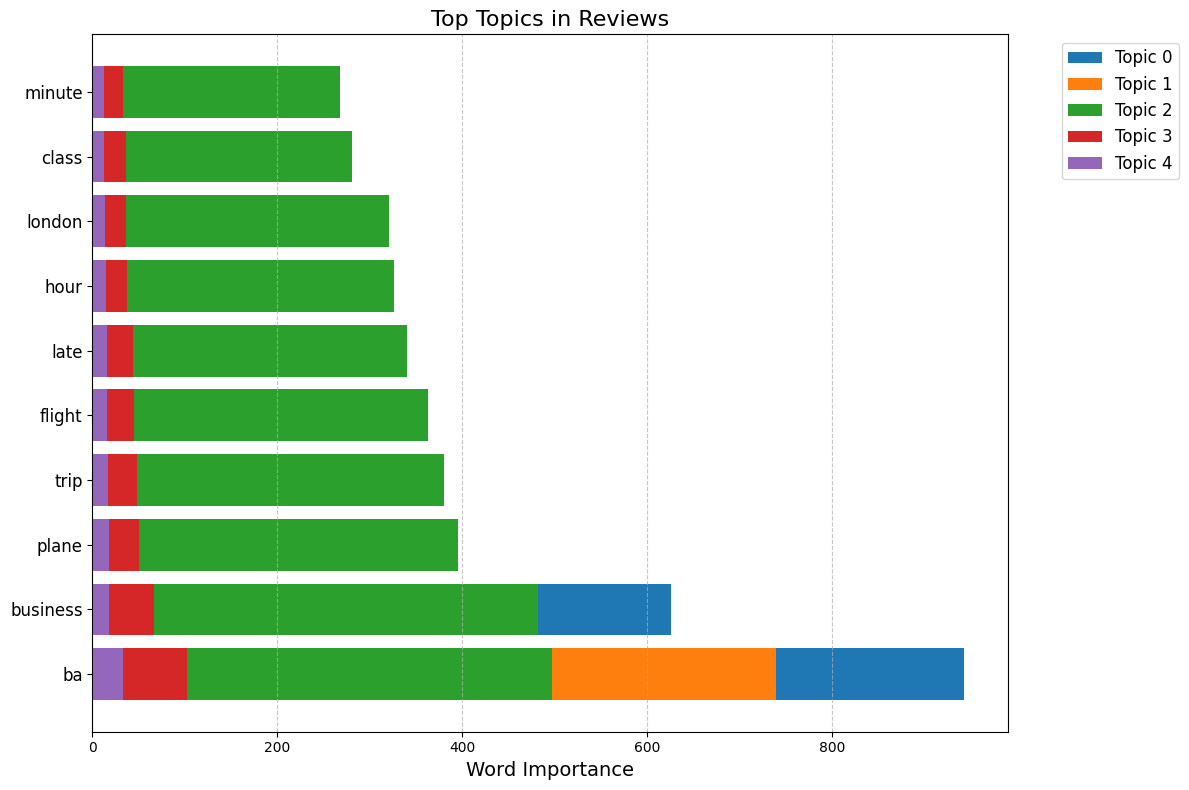

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Number of top words per topic
no_top_words = 10

# Get topic-word distributions
topic_word = lda.components_

# Plot bar chart for top topics
plt.figure(figsize=(12, 8))

# Define colors for each topic
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Loop through each topic and plot the top words
for i, topic in enumerate(topic_word):
    # Get the top words and their importance scores
    top_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
    importance_scores = topic[topic.argsort()[:-no_top_words - 1:-1]]

    # Plot horizontal bars
    plt.barh(np.arange(no_top_words), importance_scores, label=f'Topic {i}', color=colors[i])

# Customize the plot
plt.yticks(np.arange(no_top_words), top_words, fontsize=12)
plt.xlabel('Word Importance', fontsize=14)
plt.title('Top Topics in Reviews', fontsize=16)
plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust layout for better readability
plt.tight_layout()

# Save the plot
plt.savefig('top_topics.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

### Word Cloud:
Word clouds for positive and negative reviews

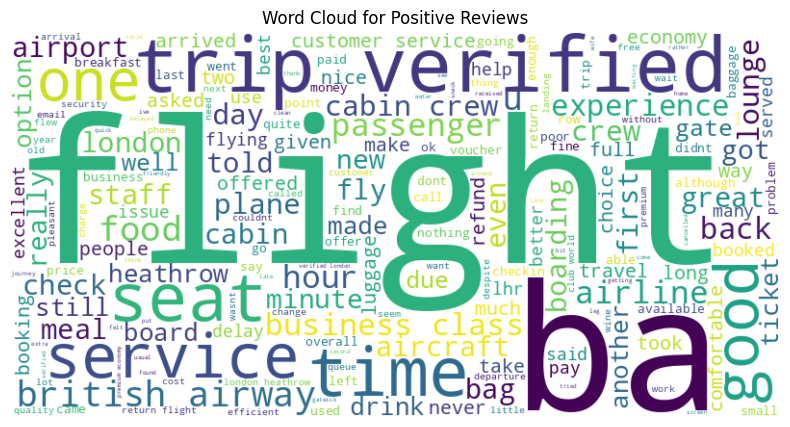

In [13]:
from wordcloud import WordCloud

# Generate word cloud for positive reviews
positive_reviews = ' '.join(df[df['Sentiment_Label'] == 'positive']['Cleaned_Review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

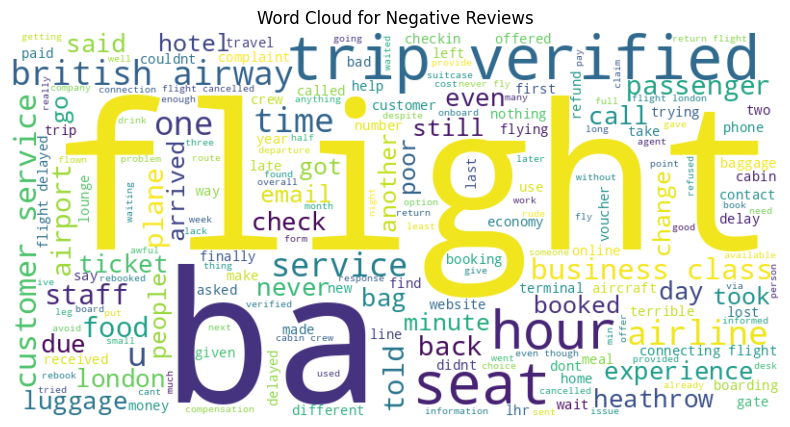

In [14]:
# Generate word cloud for negative reviews
negative_reviews = ' '.join(df[df['Sentiment_Label'] == 'negative']['Cleaned_Review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()